## Image Retrieval 실습

In [ ]:
# Import libraries
import cv2
import os
import numpy as np
import numpy.linalg as LA
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from skimage.feature import hog
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES']='0'

## Feature Extractor (Color)

In [ ]:
#  extract 3D HSV color histogram from images
class Color_Extractor:
    def __init__(self, bins):
        # store # of bins for histogram
        self.bins = bins

    # convert RGB to HSV and 
    # initialize features to quantify and represent the image
    def describe(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []

        # grab dimensions and computer center of image
        # from beginning 0 to end-1 = 1, i.e. shape[0] & shape[1]
        (h, w) = image.shape[:2]
        (cx, cy) = (int(w * 0.5), int(h * 0.5))

        # divide image into top-left, top-right, bottom-right, bottom-left corner segments as mask
        segments = [(0,cx,0,cy), (0,cx,cy,h), (cx,w,cy,h), (cx,w,0,cy)]

        # construct an elliptical mask representing the center of the image
        (axesX, axesY) = (int(w * 0.75 / 2), int(h * 0.75 / 2))
        ellipse_mask = np.zeros(image.shape[:2], dtype = "uint8")
        cv2.ellipse(ellipse_mask, (cx, cy), (axesX, axesY), 0, 0, 360, (255, 255, 255), -1)

        # loop over mask corners
        for seg in segments:
            # construct mask for each corner by np.zeros()
            corner_mask = np.zeros(image.shape[:2], dtype = 'uint8')
            # draw rectangle mask on corner_mask object
            corner_mask[seg[0]:seg[1], seg[2]:seg[3]] = 255
            corner_mask = cv2.subtract(corner_mask, ellipse_mask)

            # extract hsv histogram	from segment of image with mask	
            hist = self.histogram(image, corner_mask)

            # update feature vector
            features.extend(hist)

        # extract hsv histogram from ellipse with mask
        hist_ellipse = self.histogram(image, ellipse_mask)
        features.extend(hist_ellipse)

        return ???
    
    # Calculate the histogram of the masked region of the image
    def histogram(self,image, mask):
        # use number of bins per channel; 
        hist = cv2.calcHist([image], [0,1,2], mask, self.bins, [0, 256, 0, 256, 0, 256])
        
        # normalize histogram to obtain scale invariance
        hist = cv2.normalize(hist, None).flatten()
    
        return hist

In [ ]:
def extract_color_features(path):
    start_time = time.time()
    
    # Create a list to append feature vectors to
    features = []
    list_imgs_names = os.listdir(path)
    color_extractor = Color_Extractor((8, 8, 8))
    image_all = []
    
    # Iterate through the list of images
    for img_name in list_imgs_names:        
        # Read in each one by one
        img_path = os.path.join(path, img_name)
        image = mpimg.imread(img_path) # Read the images
        image = ???(image, (224, 224), mode='constant') # Resize the images
        image = (image * 255).astype(np.uint8)
        feature_image = np.copy(image)
        
        feature = np.array(color_extractor.describe(feature_image))
        feature = feature / ???(feature) # Feature Normalization
        features.append(feature)
        image_all.append(img_name)
    
    time_elapsed = ??? # 실행시간 측정
    
    print('Feature extraction complete in {:.02f}s'.format(time_elapsed % 60))
    
    # Return list of feature vectors
    return np.array(features), image_all

In [ ]:
def test_color_features():
    print('Extract features from data')
    path = './data'
    feats, image_list = extract_color_features(path)

    print('Extract features from query image')
    test = './test'
    feat_single, image = extract_color_features(test)
    
    # Calculate the scores
    scores  = ???(feat_single, feats.T) # Score를 구하는 방법?
    sort_ind = ???(scores)[0][::-1] # sort the scores
    scores = scores[0, sort_ind]

    # Show the results
    maxres = 10
    imlist = [image_list[index] for i, index in enumerate(sort_ind[0:maxres])]
    print ("top %d images in order are: " %maxres, imlist)

    fig=plt.figure(figsize=(16, 10))
    for i in range(len(imlist)):
        sample = imlist[i]
        img = mpimg.imread('./data' + '/' + sample)
        ax = fig.add_subplot(2, 5, i+1)
        ax.autoscale()
        plt.tight_layout()
        plt.imshow(img, interpolation='nearest')
        ax.set_title('{:.3f}%'.format(scores[i]))
        ax.axis('off')
    plt.show()

Extract features from data
Feature extraction complete in 7.12s
Extract features from query image
Feature extraction complete in 0.17s
top 10 images in order are:  ['AmidaBuddha.jpg', 'Basilique01.jpg', 'AmidaBuddha03.jpg', 'Basilique06.jpg', 'AmidaBuddha06.jpg', 'BrandenburgGate06.jpg', 'BrandenburgGate07.jpg', 'AmidaBuddha05.jpg', 'GuildHouses09.jpg', 'CommandoMemorial05.jpg']


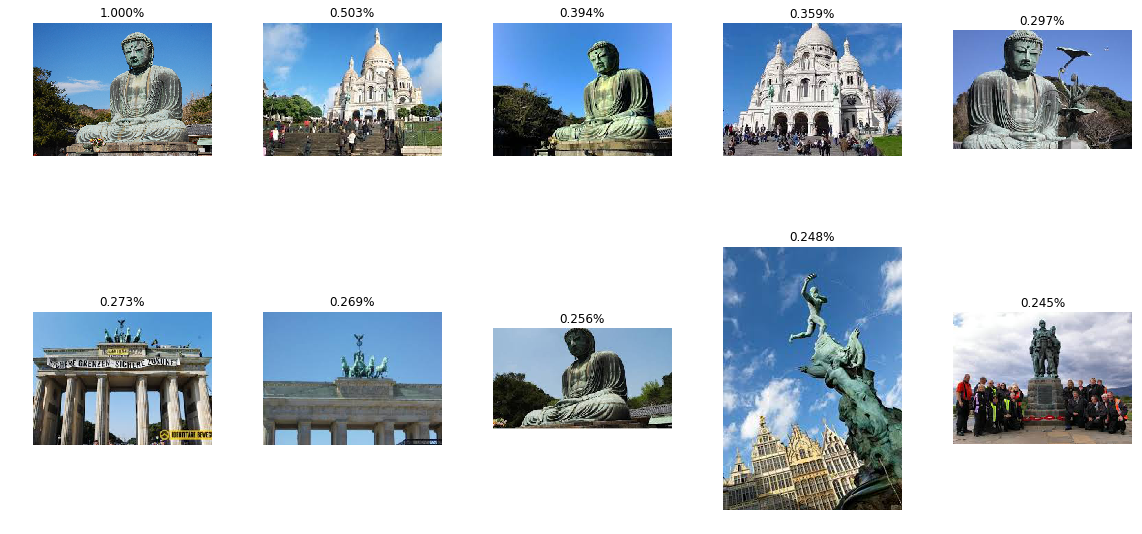

In [ ]:
test_color_features()

## Feature Extractor (HoG)

In [ ]:
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    """
    Return the hog features of the a given input image
    if vis==True, return hog_image 
    @orient : Number of orientation bins.
    @pix_per_cell : Size (in pixels) of a cell.
    @cell_per_block : Number of cells in each block. (오버랩이 허용됩니다.)
    """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [ ]:
def extract_hog_features(path):
    start_time = time.time()
    
    # Create a list to append feature vectors to
    features = []
    list_imgs_names = os.listdir(path)
    image_all = []
    
    # Iterate through the list of images
    for img_name in list_imgs_names:
        file_features = []
        
        # Read in each one by one
        img_path = os.path.join(path, img_name)
        image = mpimg.imread(img_path) # Read the images
        image = (image * 255).astype(np.uint8)
        feature_image = np.copy(image)      
        feature_image = resize(image, (224, 224), mode='constant') # Resize the images
        
        # Call get_hog_features()
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel]))
        hog_features = np.array(???(hog_features)) # Feature Flatten
        hog_features = hog_features / LA.norm(hog_features) # Feature Normalization
        features.append(hog_features)
        image_all.append(img_name)
    
    time_elapsed = time.time() - start_time
    
    print('Feature extraction complete in {:.02f}s'.format(time_elapsed % 60))
    
    # Return list of feature vectors
    return np.array(features), image_all

In [ ]:
def test_hog_features():
    print('Extract features from data')
    path = './data'
    feats, image_list = extract_hog_features(path)

    print('Extract features from query image')
    test = './test'
    feat_single, image = extract_hog_features(test)
    
    # Calculate the scores
    scores  = ???
    sort_ind = np.argsort(scores)[0][::-1] # sort the scores
    scores = scores[0, sort_ind]

    # Show the results
    maxres = 10
    imlist = [image_list[index] for i, index in enumerate(sort_ind[0:maxres])]
    print ("top %d images in order are: " %maxres, imlist)

    fig=plt.figure(figsize=(16, 10))
    for i in range(len(imlist)):
        sample = imlist[i]
        img = mpimg.imread('./data' + '/' + sample)
        ax = fig.add_subplot(2, 5, i+1)
        ax.autoscale()
        plt.tight_layout()
        plt.imshow(img, interpolation='nearest')
        ax.set_title('{:.3f}%'.format(scores[i]))
        ax.axis('off')
    plt.show()

Extract features from data
Feature extraction complete in 21.63s
Extract features from query image
Feature extraction complete in 0.24s
top 10 images in order are:  ['AmidaBuddha.jpg', 'None11.jpg', 'None08.jpg', 'BigBen09.jpg', 'BigBen08.jpg', 'None06.jpg', 'BigBen.jpg', 'None03.jpg', 'BigBen06.jpg', 'None10.jpg']


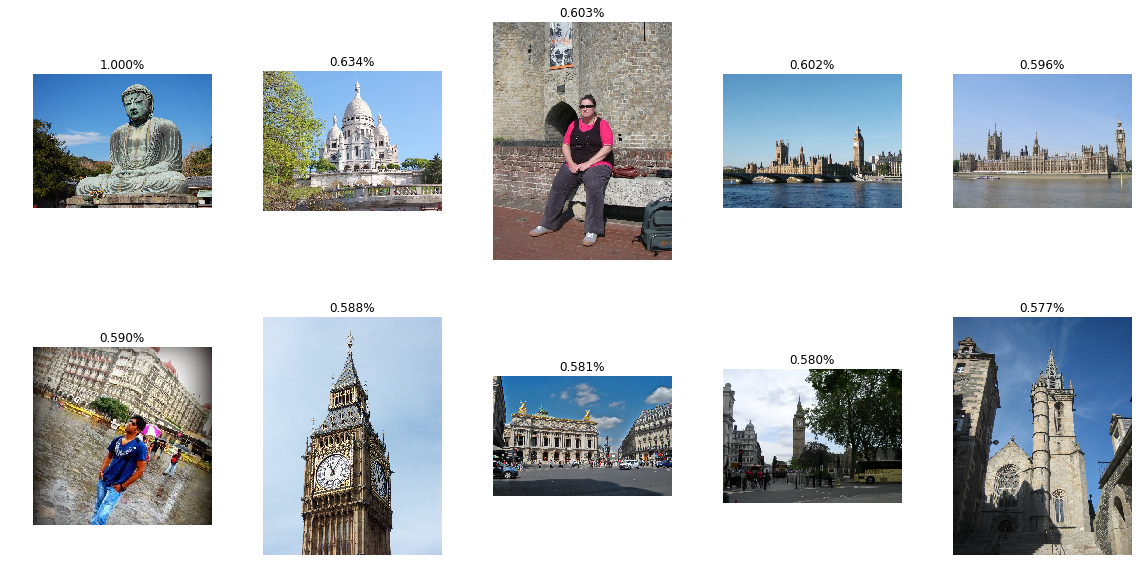

In [ ]:
test_hog_features()

## Feature Extractor (VGG19)

In [ ]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        self.vgg19 = torchvision.models.vgg19(pretrained = True) # vgg 19 model is imported
        #print(vgg19)
        self.vgg19.classifier = self.vgg19.classifier[0:4]
        
    def forward(self, x):
        out = self.vgg19(x)
        return out

# Set our model with pre-trained model 
vgg19 = VGG19().cuda()

## Feature Extractor (ResNet)

In [ ]:
# Create the network to extract the features
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        resnet = torchvision.models.resnet50(pretrained = True) # resnet 50 model is imported
        
        #print(resnet)
        self.conv1 = ???
        self.bn1 = ???
        self.maxpool = ???
        self.layer1 = ???
        self.layer2 = ???
        self.layer3 = ???
        self.layer4 = ???

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, kernel_size=7, stride=7)

        return out

# Set our model with pre-trained model 
resnet = ResNet().cuda()

In [ ]:
# Extract ConvNet Features (VGG19, ResNet)
def extract_deep_features(path, feature_extractor, feature_size):
    start_time = time.time()
    
    list_imgs_names = os.listdir(path) #list_imgs_names
    N = len(list_imgs_names)
    feature_all = np.zeros((N, feature_size)) # create an array to store features
    image_all = [] # define empy array to store image names
    
    transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    # extract features 
    for index, img_name in enumerate(list_imgs_names):
        img_path = os.path.join(path, img_name)
        
        # Image Read & Resize
        image_np = Image.open(img_path) # Read the images
        image_np = np.array(image_np)
        image_np = resize(image_np, (224, 224), mode='constant') # Resize the images
        image_np = torch.from_numpy(image_np).permute(2, 0, 1).float()
        image_np = transform(image_np)
        image_np = Variable(image_np.unsqueeze(0))   #bs, c, h, w
        image_np = image_np.cuda()
        
        # Extract Feature
        feature = feature_extractor(image_np)
        feature = feature.squeeze().cpu().data.numpy()
        feature = feature.reshape((1, feature_size)) # Feature Flatten
        feature = feature / LA.norm(feature) # Feature Normalization
        feature_all[index] = feature
        image_all.append(img_name)

    time_elapsed = time.time() - start_time

    print('Feature extraction complete in {:.02f}s'.format(time_elapsed % 60))

    return feature_all, image_all

In [ ]:
def test_deep_feature(feature_extractor, feature_size):
    # Extract features from the dataset
    print('Extract features from data')
    path = './data'
    feats, image_list = extract_deep_features(path, feature_extractor, feature_size=feature_size)

    # test image path
    print('Extract features from query image')
    test = './test'
    feat_single, image = extract_deep_features(test, feature_extractor, feature_size=feature_size)
    
    # Calculate the scores
    scores  = np.dot(feat_single, feats.T)
    sort_ind = np.argsort(scores)[0][::-1] # sort the scores
    scores = scores[0, sort_ind]

    # Show the results
    maxres = 10
    imlist = [image_list[index] for i, index in enumerate(sort_ind[0:maxres])]
    print ("top %d images in order are: " %maxres, imlist)

    fig=plt.figure(figsize=(16, 10))
    for i in range(len(imlist)):
        sample = imlist[i]
        img = mpimg.imread('./data' + '/' + sample)
        ax = fig.add_subplot(2, 5, i+1)
        ax.autoscale()
        plt.tight_layout()
        plt.imshow(img, interpolation='nearest')
        ax.set_title('{:.3f}%'.format(scores[i]))
        ax.axis('off')
    plt.show()

Extract features from data
Feature extraction complete in 10.76s
Extract features from query image
Feature extraction complete in 0.23s
top 10 images in order are:  ['AmidaBuddha.jpg', 'AmidaBuddha03.jpg', 'AmidaBuddha07.jpg', 'CommandoMemorial.jpg', 'AmidaBuddha08.jpg', 'GuildHouses.jpg', 'None04.jpg', 'None10.jpg', 'CommandoMemorial10.jpg', 'AmidaBuddha06.jpg']


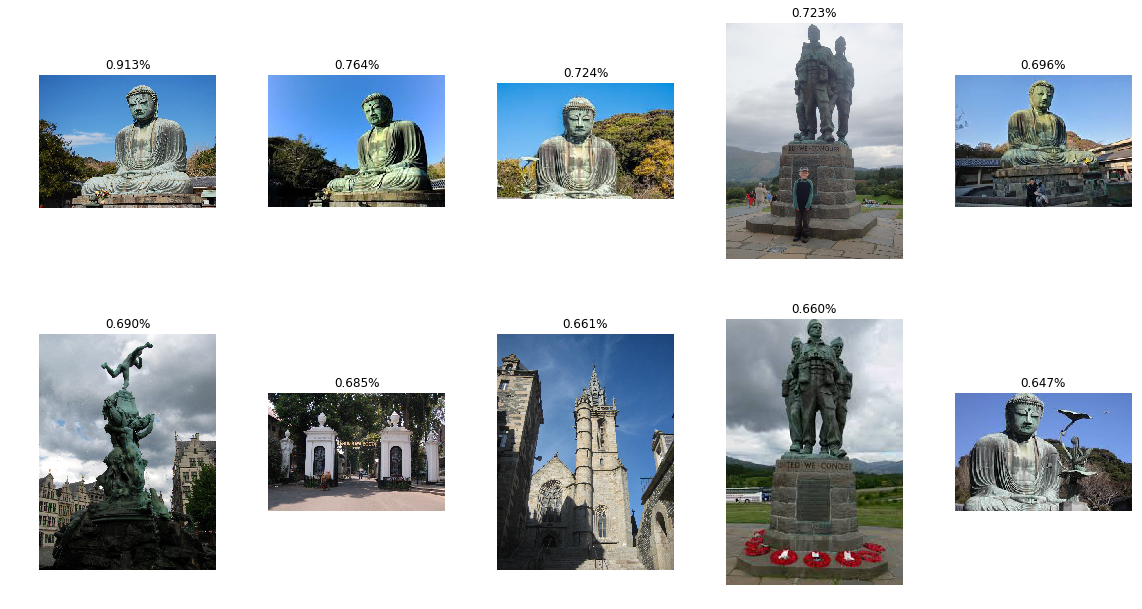

In [ ]:
# VGG19 Image Retrieval Results
test_deep_feature(vgg19, feature_size=4096)

Extract features from data
Feature extraction complete in 14.26s
Extract features from query image
Feature extraction complete in 0.25s
top 10 images in order are:  ['AmidaBuddha.jpg', 'AmidaBuddha07.jpg', 'AmidaBuddha06.jpg', 'AmidaBuddha03.jpg', 'AmidaBuddha05.jpg', 'AmidaBuddha01.jpg', 'AmidaBuddha08.jpg', 'Basilique09.jpg', 'AmidaBuddha04.jpg', 'AmidaBuddha02.jpg']


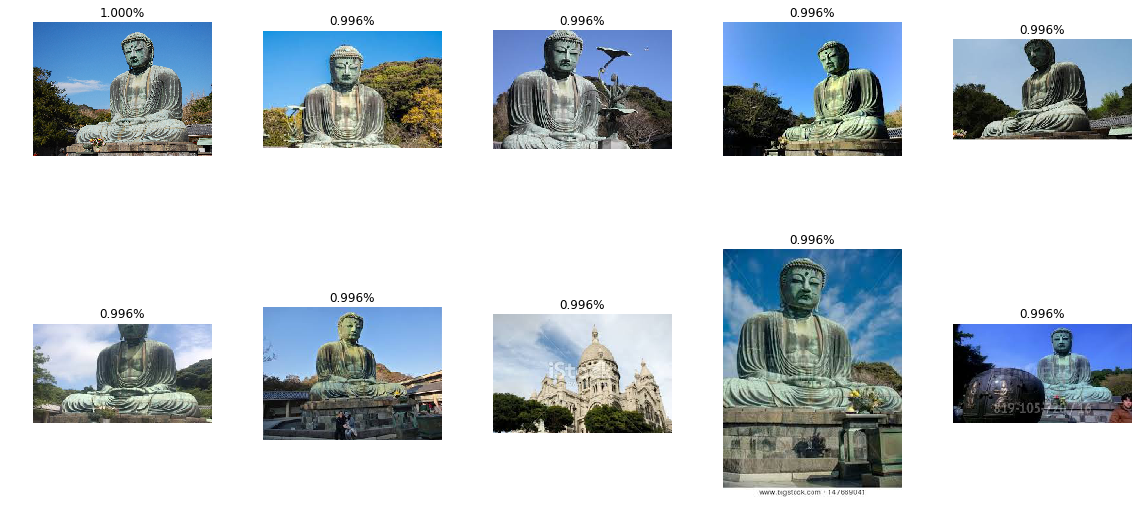

In [ ]:
# ResNet50 Image Retrieval Results
test_deep_feature(resnet, feature_size=2048)